In [32]:
#Libraries 
import pandas as pd
pd.set_option("display.max_rows", None)  # show all rows
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10,6) #default figure size of Matplolib
import seaborn as sns
import numpy as np

#text processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Getting the Data 

In [2]:
# import dataset
df = pd.read_csv("../data/raw/fake_job_postings.csv")

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', None)
print(df.head(5))

   job_id                                      title            location department salary_range                                    company_profile                                        description                                       requirements                                           benefits  telecommuting  has_company_logo  has_questions employment_type required_experience required_education                   industry              function  fraudulent
0       1                           Marketing Intern    US, NY, New York  Marketing          NaN  We're Food52, and we've created a groundbreaki...  Food52, a fast-growing, James Beard Award-winn...  Experience with content management systems a m...                                                NaN              0                 1              0           Other          Internship                NaN                        NaN             Marketing           0
1       2  Customer Service - Cloud Video Production      NZ, , Auckla

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

## Data exploration 

### Exploration (duplicate, missing)

In [6]:
df.duplicated().sum() #chekc for duplicates

np.int64(0)

In [7]:
df.isnull().sum() #check for missing values

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [8]:
#percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100
missing_percentage.sort_values(ascending=False, inplace=True)
print(missing_percentage)

salary_range           83.959732
department             64.580537
required_education     45.329978
benefits               40.335570
required_experience    39.429530
function               36.101790
industry               27.421700
employment_type        19.412752
company_profile        18.501119
requirements           15.078300
location                1.935123
description             0.005593
title                   0.000000
job_id                  0.000000
telecommuting           0.000000
has_questions           0.000000
has_company_logo        0.000000
fraudulent              0.000000
dtype: float64


In [9]:
#Remove rows for columns with  <10% missing values
columns_remove_null = ['location','description']
df1 = df.dropna(subset= columns_remove_null)
df1.isnull().sum()

job_id                     0
title                      0
location                   0
department             11251
salary_range           14687
company_profile         3245
description                0
requirements            2519
benefits                6961
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3256
required_experience     6796
required_education      7820
industry                4654
function                6192
fraudulent                 0
dtype: int64

Several features exhibit a high proportion of missing values. Missingness in the dataset may reflects real-world job posting behavior and is potentially informative for fraud detection. Therefore, missing values were retained and explicitly encoded instead of removing observations.

### Numerical Transformation of 'salary_range'

In [10]:
df1['salary_range'].value_counts() #check unique values in salary range

salary_range
0-0                     141
40000-50000              66
30000-40000              55
25000-30000              37
45000-67000              37
30000-50000              32
70000-90000              30
80000-100000             30
35000-45000              30
50000-80000              29
55000-75000              28
60000-80000              28
30000-35000              27
40000-60000              27
50000-70000              27
40000-45000              27
25000-35000              26
50000-60000              23
45000-50000              22
40000-70000              21
35000-40000              20
100000-120000            20
80000-120000             19
35000-50000              18
18000-20000              18
80000-110000             17
30000-45000              17
20000-25000              17
60000-75000              17
140000-150000            16
50000-65000              16
20000-30000              16
4500-4500                16
65000-80000              15
45000-60000              15
90000-1

In [11]:
# Convert salary_range from categorical to numeric data.
# Split the range into minimum and maximum.
df1[['salary_min', 'salary_max']] = df1['salary_range'].str.split('-', expand=True)  

# Convert both columns into numeric.
df1['salary_min'] = pd.to_numeric(df1['salary_min'], errors='coerce')
df1['salary_max'] = pd.to_numeric(df1['salary_max'], errors='coerce')  

# Create new column: average salary.
df1['average_salary'] = (df1['salary_min'] + df1['salary_max']) / 2
df1['average_salary'].fillna(0, inplace=True)
# Create new column: average salary.
df1['average_salary'] = (df1['salary_min'] + df1['salary_max']) / 2
df1['average_salary'].fillna(0, inplace=True)

# Create new column: salary difference.
df1['salary_diff'] = (df1['salary_max'] - df1['salary_min'])

# Drop original salary columns.
df1.drop(columns=['salary_range', 'salary_min', 'salary_max'], inplace=True) 

# Create new column: salary specified.
df1['salary_specified'] = df1['average_salary'].notnull().astype(int)
df1.loc[df1['average_salary'] == 0.0, 'salary_specified'] = 0

C:\Users\User\AppData\Local\Temp\ipykernel_9768\399385486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[['salary_min', 'salary_max']] = df1['salary_range'].str.split('-', expand=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9768\399385486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[['salary_min', 'salary_max']] = df1['salary_range'].str.split('-', expand=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9768\399385486.py:6: SettingWithCopyWarning: 
A value is trying to be set on a co

### Text cleaning 

In [12]:
#Stopwords removal,tokenize, stemming


stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
def clean_text_simple(text):
    if isinstance(text, str):
        # remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # split on spaces
        tokens = text.lower().split()
        # remove stopwords
        cleaned_tokens = [w for w in tokens if w not in stop_words]
        return ' '.join(cleaned_tokens)
    else:
        return ''

# List of text features in your DataFrame
text_features = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']

# Loop through each text feature and apply text cleaning
for feature in text_features:
    df1[feature] = df1[feature].apply(clean_text_simple)

C:\Users\User\AppData\Local\Temp\ipykernel_9768\128765351.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[feature] = df1[feature].apply(clean_text_simple)


In [13]:
# Define the list of text features
text_features = ['company_profile', 'description', 'requirements', 'benefits']

# Iterate over each text feature and create a binary indicator
for feature in text_features:
    df1[f'{feature}_specified'] = df1[feature].apply(lambda x: 1 if x.strip() else 0)

C:\Users\User\AppData\Local\Temp\ipykernel_9768\352652299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[f'{feature}_specified'] = df1[feature].apply(lambda x: 1 if x.strip() else 0)
C:\Users\User\AppData\Local\Temp\ipykernel_9768\352652299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[f'{feature}_specified'] = df1[feature].apply(lambda x: 1 if x.strip() else 0)
C:\Users\User\AppData\Local\Temp\ipykernel_9768\352652299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [14]:
#Split 'location' into simpler features
split_result = df1['location'].str.split(', ', expand=True)
print(split_result.head())

#result shows not all rows of location contains 3 components

                  0
0    us ny new york
1       nz auckland
2       us ia wever
3  us dc washington
4  us fl fort worth


In [15]:
# Split the 'location' column into three columns, regardless of whether all components are present
split_result = df1['location'].str.split(' ', n=2, expand=True)

# Create separate columns for country, state, and city
df1['country'] = split_result[0]
df1['state'] = split_result[1] if len(split_result.columns) > 1 else None
df1['city'] = split_result[2] if len(split_result.columns) > 2 else None

#Drop original column
df1.drop(columns=['location'], inplace=True)

#Replace all empty value with "Unspecified" in categorical features
categorical_features = ['country', 'state', 'city','employment_type','required_experience','required_education','industry','function']
df1[categorical_features] = df1[categorical_features].fillna('Unspecified')

C:\Users\User\AppData\Local\Temp\ipykernel_9768\4257543473.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['country'] = split_result[0]
C:\Users\User\AppData\Local\Temp\ipykernel_9768\4257543473.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['state'] = split_result[1] if len(split_result.columns) > 1 else None
C:\Users\User\AppData\Local\Temp\ipykernel_9768\4257543473.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [16]:
df1.head(5)

,job_id,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,average_salary,salary_diff,salary_specified,company_profile_specified,description_specified,requirements_specified,benefits_specified,country,state,city
0,1,marketing intern,marketing,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management systems major pl...,,0,1,0,...,0.0,NaN,0,1,1,1,0,us,ny,new york
1,2,customer service cloud video production,success,90 seconds worlds cloud video production servi...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part 90 seconds team gainexperie...,0,1,0,...,0.0,NaN,0,1,1,1,1,nz,auckland,Unspecified
2,3,commissioning machinery assistant cma,,valor services provides workforce solutions me...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,,0,1,0,...,0.0,NaN,0,1,1,1,0,us,ia,wever
3,4,account executive washington dc,sales,passion improving quality life geography heart...,company esri – environmental systems research ...,education bachelor’s master’s gis business adm...,culture anything corporate—we collaborative cr...,0,1,0,...,0.0,NaN,0,1,1,1,1,us,dc,washington
4,5,bill review manager,,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefits offered,0,1,1,...,0.0,NaN,0,1,1,1,1,us,fl,fort worth


In [17]:
(df1['country'].unique()).tolist()
df1['country'].nunique()

132

### EDA

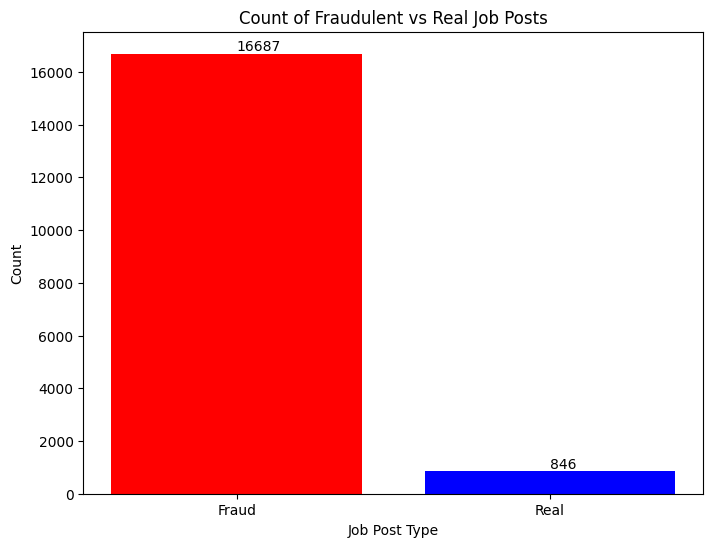

In [18]:
# Count the number of fraudulent and real job posts
fraud_count = len(df1[df1['fraudulent']==0])
real_count = len(df1[df1['fraudulent']==1])

#bar plot 
plt.figure(figsize=(8, 6))
bars = plt.bar(['Fraud','Real'], [fraud_count, real_count], color=['red', 'blue'])
plt.title('Count of Fraudulent vs Real Job Posts')
plt.xlabel('Job Post Type')
plt.ylabel('Count')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), va='bottom')

plt.show()


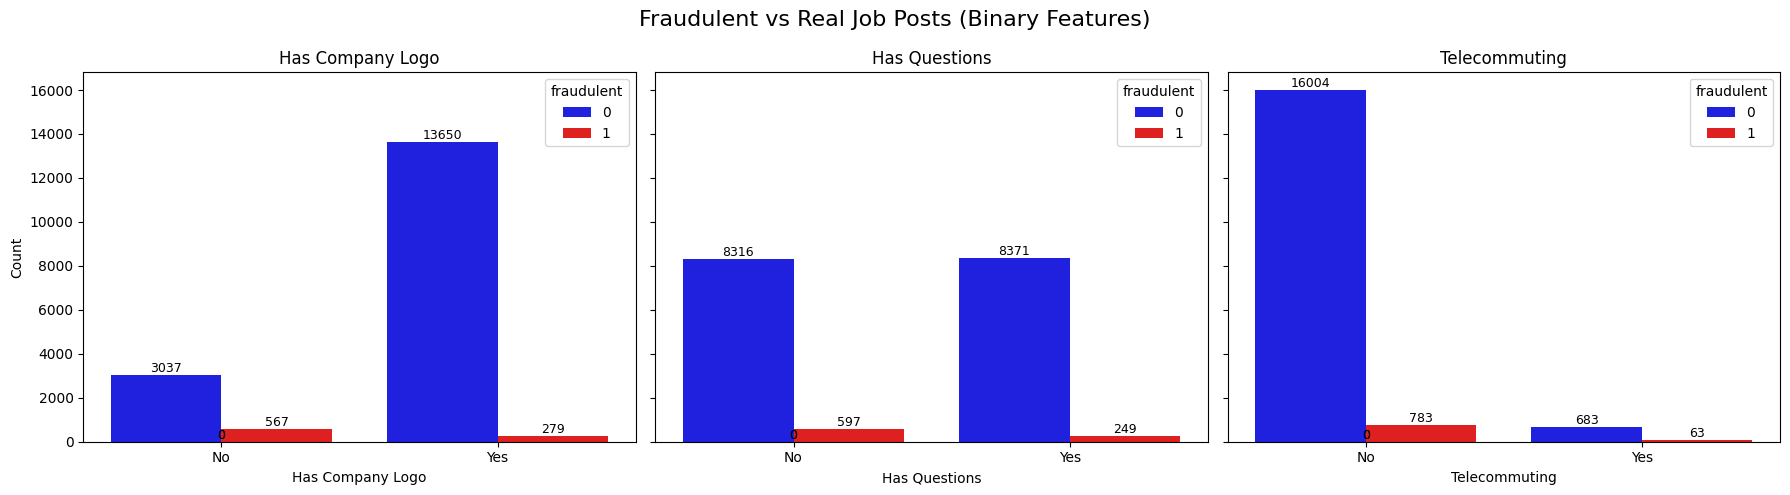

In [29]:
features = ['has_company_logo', 'has_questions', 'telecommuting']

def plot_binary_vs_fraud(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, feature in zip(axes, features):
        sns.countplot(
            x=feature,
            hue='fraudulent',
            data=df,
            palette=['blue', 'red'],
            ax=ax
        )

        # Add numbers on top of bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2,
                height,
                int(height),
                ha='center',
                va='bottom',
                fontsize=9
            )

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['No', 'Yes'])
        ax.set_xlabel(feature.replace('_', ' ').title())
        ax.set_title(feature.replace('_', ' ').title())

    axes[0].set_ylabel('Count')
    fig.suptitle('Fraudulent vs Real Job Posts (Binary Features)', fontsize=16)
    plt.tight_layout()
    plt.show()


plot_binary_vs_fraud(df1)


In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17533 entries, 0 to 17879
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   job_id                     17533 non-null  int64  
 1   title                      17533 non-null  object 
 2   department                 17533 non-null  object 
 3   company_profile            17533 non-null  object 
 4   description                17533 non-null  object 
 5   requirements               17533 non-null  object 
 6   benefits                   17533 non-null  object 
 7   telecommuting              17533 non-null  int64  
 8   has_company_logo           17533 non-null  int64  
 9   has_questions              17533 non-null  int64  
 10  employment_type            17533 non-null  object 
 11  required_experience        17533 non-null  object 
 12  required_education         17533 non-null  object 
 13  industry                   17533 non-null  object 


In [35]:
# Function to count words in text
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0


# Apply the function to calculate word counts for company profile and job requirements in df1
df1['company_profile_word_count'] = df1['company_profile'].apply(count_words)
df1['requirements_word_count'] = df1['requirements'].apply(count_words)


C:\Users\User\AppData\Local\Temp\ipykernel_9768\4213284587.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['company_profile_word_count'] = df1['company_profile'].apply(count_words)
C:\Users\User\AppData\Local\Temp\ipykernel_9768\4213284587.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['requirements_word_count'] = df1['requirements'].apply(count_words)


In [37]:
from scipy.stats import ttest_ind, mannwhitneyu

# Split the dataset into two groups based on 'fraudulent' column
fraudulent_group = df1[df1['fraudulent'] == 1]
non_fraudulent_group = df1[df1['fraudulent'] == 0]

# Perform statistical tests for 'company_profile' word count
t_stat_cp, p_value_cp = ttest_ind(fraudulent_group['company_profile_word_count'], non_fraudulent_group['company_profile_word_count'])

# Perform statistical tests for 'requirements' word count
t_stat_req, p_value_req = ttest_ind(fraudulent_group['requirements_word_count'], non_fraudulent_group['requirements_word_count'])

# Print the p-values
print("P-value for 'company_profile':", p_value_cp)
print("P-value for 'requirements':", p_value_req)

P-value for 'company_profile': 2.1640032191194064e-100
P-value for 'requirements': 8.060220641804172e-12


### Data transformation